![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/05.6.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb)

# Improved_Entity_Resolution_with_SentenceChunkEmbeddings

Enrich embeddings of chunks to get more accurate resolution results


In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs==5.1.0

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, medical, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install()

In [ ]:
from johnsnowlabs import nlp, medical, visual

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

In [ ]:
spark

<h1>!!! Warning !!!</h1>

**If you get an error related to Java port not found 55, it is probably because that the Colab memory cannot handle the model and the Spark session died. In that case, try on a larger machine or restart the kernel at the top and then come back here and rerun.**

## Resolver Pipeline

In [ ]:
documenter = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("documents")

sentence_detector = nlp.SentenceDetector()\
    .setInputCols("documents")\
    .setOutputCol("sentences")

tokenizer = nlp.Tokenizer()\
    .setInputCols("sentences")\
    .setOutputCol("token")

embeddings = nlp.WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", 'en', 'clinical/models')\
    .setInputCols(["sentences","token"])\
    .setOutputCol("embeddings")

ner = medical.NerModel()\
    .pretrained("ner_jsl_greedy", "en", "clinical/models")\
    .setInputCols("sentences", "token","embeddings")\
    .setOutputCol("ner")

ner_converter = medical.NerConverterInternal()\
    .setInputCols("sentences", "token", "ner")\
    .setOutputCol("ner_chunk")

#Get average sentence-chunk Bert embeddings
sentence_chunk_embeddings = medical.BertSentenceChunkEmbeddings\
    .pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["sentences", "ner_chunk"])\
    .setOutputCol("sentence_chunk_embeddings")\
    .setChunkWeight(0.5) #default : 0.5

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl_greedy download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
[OK!]


In [ ]:
def create_pipeline_model(resolver, whiteListed):

  ner_converter = medical.NerConverterInternal()\
    .setInputCols("sentences", "token", "ner")\
    .setOutputCol("ner_chunk")\
    .setWhiteList(whiteListed)

  pipeline = nlp.Pipeline().setStages(
  [
      documenter,
      sentence_detector,
      tokenizer,
      embeddings,
      ner,
      ner_converter,
      sentence_chunk_embeddings,
      resolver
  ])

  return nlp.LightPipeline(pipeline.fit(spark.createDataFrame([['']]).toDF("text")))


In [ ]:
icd_resolver = medical.SentenceEntityResolverModel.pretrained('sbiobertresolve_icd10cm', 'en', 'clinical/models')\
            .setInputCols(["sentence_chunk_embeddings"]) \
            .setOutputCol("resolution")\
            .setDistanceFunction("EUCLIDEAN")

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

icd_model

sbiobertresolve_icd10cm download started this may take some time.
[OK!]


In [ ]:
cpt_resolver = medical.SentenceEntityResolverModel.pretrained('sbiobertresolve_cpt_procedures_augmented', 'en', 'clinical/models')\
            .setInputCols(["sentence_chunk_embeddings"]) \
            .setOutputCol("resolution")\
            .setDistanceFunction("EUCLIDEAN")

cpt_whiteListed = ['Test'] #['External_body_part_or_region', 'Internal_organ_or_component', 'Direction','Test', 'Procedure']

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

sbiobertresolve_cpt_procedures_augmented download started this may take some time.
[OK!]


**Helper function to process output**

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

def print_result(res):
    def get_res(col):
        dists = col.metadata['all_k_cosine_distances'].split(':::')[:5]
        resos = col.metadata['all_k_resolutions'].split(':::')[:5]
        reses = col.metadata['all_k_results'].split(':::')[:5]
        return pd.DataFrame({'code': reses, 'resolutions': resos , 'dist': dists})
    df_arr = []
    for chunk, resol in zip(res['ner_chunk'], res['resolution']):
        t_df = get_res(resol)
        t_df['chunk'] = chunk.result
        t_df['entity'] = chunk.metadata['entity']

        df_arr.append(t_df)

    return pd.concat(df_arr, axis=0)


## Examples

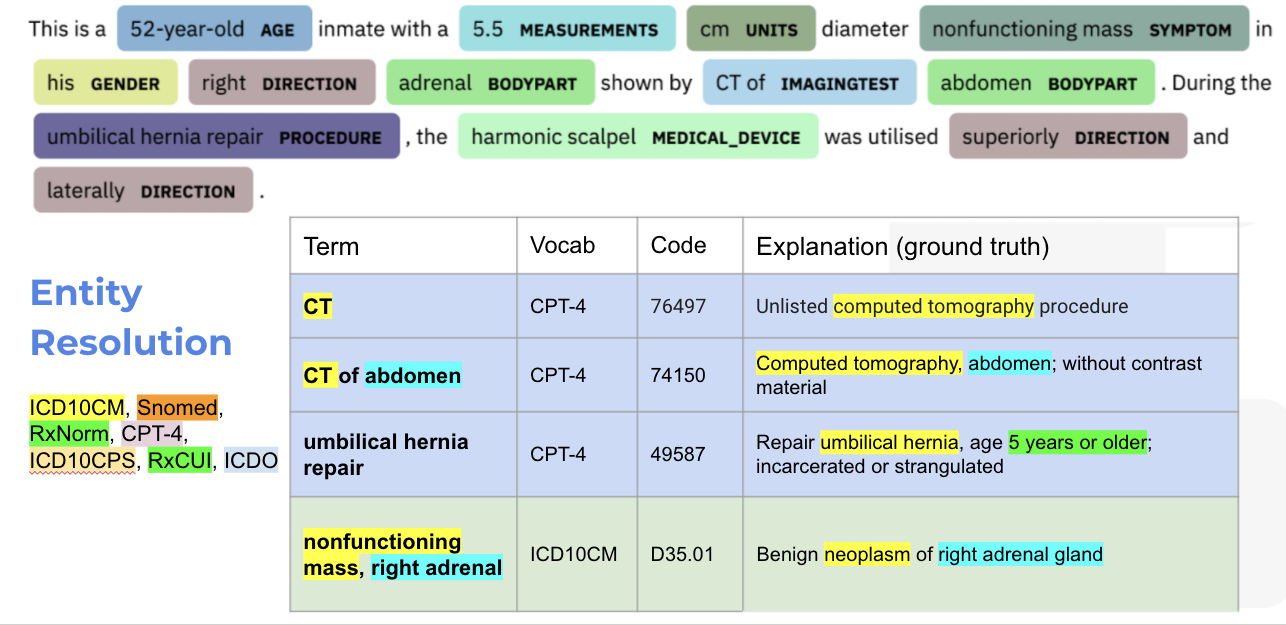

## CPT4

In [ ]:
sentence_chunk_embeddings.setChunkWeight(0.5)

cpt_whiteListed = ['Test','Procedure']

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

text = "There is a benign tumor in his right adrenal shown by CT from his abdomen."

result = cpt_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,1010526,"Computed tomography, abdomen [Computed tomography, abdomen]",0.1901,CT,Test
1,73200,"Computed tomography of upper limb (procedure) [Computed tomography, upper extremity; without contrast material]",0.2042,CT,Test
2,73206,"Computed tomography of upper limb (procedure) [Computed tomographic angiography, upper extremity, with contrast material(s), including noncontrast images, if performed, and image postprocessing]",0.2042,CT,Test
3,73202,"Computed tomography of upper limb (procedure) [Computed tomography, upper extremity; without contrast material, followed by contrast material(s) and further sections]",0.2042,CT,Test
4,76497,"Computed Tomography [Unlisted computed tomography procedure (eg, diagnostic, interventional)]",0.1960,CT,Test


In [ ]:
sentence_chunk_embeddings.setChunkWeight(1.0)

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

text = "There is a benign tumor in his right adrenal shown by  CT from his abdomen."

result = cpt_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,76497,"Computed Tomography [Unlisted computed tomography procedure (eg, diagnostic, interventional)]",0.1133,CT,Test
1,77073,"Scanogram [Bone length studies (orthoroentgenogram, scanogram)]",0.1409,CT,Test
2,91110,"Clinical imaging [Gastrointestinal tract imaging, intraluminal (eg, capsule endoscopy), esophagus through ileum, with interpretation and report]",0.1566,CT,Test
3,1015087,Computed Tomography Guidance [Computed Tomography Guidance],0.1656,CT,Test
4,1010526,"Computed tomography, abdomen [Computed tomography, abdomen]",0.1692,CT,Test


### Another example

In [ ]:
sentence_chunk_embeddings.setChunkWeight(0.5)

cpt_whiteListed = ['Test','Procedure']

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

text = "extraction of cyst in kidney"

result = cpt_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,50280,Decortication of cyst of kidney [Excision or unroofing of cyst(s) of kidney],0.0877,extraction of cyst,Procedure
1,50290,Excision of perinephric cyst (procedure) [Excision of perinephric cyst],0.1048,extraction of cyst,Procedure
2,50390,"Therapeutic aspiration of renal cyst (procedure) [Aspiration and/or injection of renal cyst or pelvis by needle, percutaneous]",0.1151,extraction of cyst,Procedure
3,68020,"Incision of conjunctiva with drainage of cyst (procedure) [Incision of conjunctiva, drainage of cyst]",0.1405,extraction of cyst,Procedure
4,62162,"Excision of cyst of brain meninges (procedure) [Neuroendoscopy, intracranial; with fenestration or excision of colloid cyst, including placement of external ventricular catheter for drainage]",0.1788,extraction of cyst,Procedure


In [ ]:
sentence_chunk_embeddings.setChunkWeight(1)

cpt_whiteListed = ['Test','Procedure']

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

text = "extraction of cyst in kidney"

result = cpt_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,68020,"Incision of conjunctiva with drainage of cyst (procedure) [Incision of conjunctiva, drainage of cyst]",0.1411,extraction of cyst,Procedure
1,50290,Excision of perinephric cyst (procedure) [Excision of perinephric cyst],0.1537,extraction of cyst,Procedure
2,25145,"Excision of sequestrum [Sequestrectomy (eg, for osteomyelitis or bone abscess), forearm and/or wrist]",0.1592,extraction of cyst,Procedure
3,60200,"Excision of cyst of thyroid (procedure) [Excision of cyst or adenoma of thyroid, or transection of isthmus]",0.1679,extraction of cyst,Procedure
4,39200,Resection of mediastinal cyst [Resection of mediastinal cyst],0.1678,extraction of cyst,Procedure




## ICD-10

In [ ]:
sentence_chunk_embeddings.setChunkWeight(1.0)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = "There is a benign tumor in his right adrenal shown by  CT from his abdomen."

result = icd_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,D369,"Benign neoplasm, unspecified site",0.1031,benign tumor,Oncological
1,D159,"Benign neoplasm of intrathoracic organ, unspecified",0.1299,benign tumor,Oncological
2,D219,"Benign neoplasm of connective and other soft tissue, unspecified",0.1344,benign tumor,Oncological
3,D3190,Benign neoplasm of unspecified part of unspecified eye,0.1385,benign tumor,Oncological
4,D141,Benign neoplasm of larynx,0.1360,benign tumor,Oncological


In [ ]:
sentence_chunk_embeddings.setChunkWeight(0.5)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = "There is a benign tumor in his right adrenal shown by  CT from his abdomen."

result = icd_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,D3500,Benign neoplasm of unspecified adrenal gland,0.1080,benign tumor,Oncological
1,D3191,Benign neoplasm of unspecified part of right eye,0.1206,benign tumor,Oncological
2,D3A00,Benign carcinoid tumor of unspecified site,0.1382,benign tumor,Oncological
3,D3190,Benign neoplasm of unspecified part of unspecified eye,0.1358,benign tumor,Oncological
4,D3161,Benign neoplasm of unspecified site of right orbit,0.1362,benign tumor,Oncological


#### Another example

In [ ]:
# Relying only on chunk - we get less specific results

sentence_chunk_embeddings.setChunkWeight(1.0)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = "She complains of pain in right leg."

result = icd_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,R072,Precordial pain,0.0795,pain,Symptom
1,R6884,Jaw pain,0.0799,pain,Symptom
2,R1033,Periumbilical pain,0.0825,pain,Symptom
3,R141,Gas pain,0.0884,pain,Symptom
4,R0782,Intercostal pain,0.0919,pain,Symptom


In [ ]:
# Using the entire sentence to get embedding

sentence_chunk_embeddings.setChunkWeight(0.5)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = "She complains of pain in right leg."

result = icd_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,M79661,Pain in right lower leg,0.0698,pain,Symptom
1,R072,Precordial pain,0.0708,pain,Symptom
2,R1031,Right lower quadrant pain,0.0737,pain,Symptom
3,R1011,Right upper quadrant pain,0.0721,pain,Symptom
4,R1033,Periumbilical pain,0.0783,pain,Symptom


**Explanation:**

Even though the chunk itself does not specify right leg, we can still get that information from surrounding text

The "setChunkWeight" parameter has a default value of 0.5 - meaning taking equal representation of the cunk and sentence. Setting it to 1.0 would mean discarding the context information completely and only relying on the chunk, while a value of 0.0 would mean only relying on information in the sentence, not the chunk.

In [ ]:
# a more elaborate example

sentence_chunk_embeddings.setChunkWeight(0.5)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = """A 20 year old female patient badly tripped while going down stairs. She complains of right leg pain.
Her x-ray showed right hip fracture. Hair line fractures also seen on the left knee joint.
She also suffered from trauma and slight injury on the head.

OTHER CONDITIONS: She was also recently diagnosed with diabetes, which is of type 2.
"""

result = icd_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,M79661,Pain in right lower leg,0.0667,leg pain,Symptom
1,R1031,Right lower quadrant pain,0.0706,leg pain,Symptom
2,R1012,Left upper quadrant pain,0.0705,leg pain,Symptom
3,I83811,Varicose veins of right lower extremity with pain,0.0795,leg pain,Symptom
4,G546,Phantom limb syndrome with pain,0.0776,leg pain,Symptom
0,M84451S,"Pathological fracture, right femur, sequela",0.1119,hip fracture,Injury_or_Poisoning
1,M84351S,"Stress fracture, right femur, sequela",0.1301,hip fracture,Injury_or_Poisoning
2,M84459P,"Pathological fracture, hip, unspecified, subsequent encounter for fracture with malunion",0.1430,hip fracture,Injury_or_Poisoning
3,M84451A,"Pathological fracture, right femur, initial encounter for fracture",0.1392,hip fracture,Injury_or_Poisoning
4,M84421S,"Pathological fracture, right humerus, sequela",0.1463,hip fracture,Injury_or_Poisoning


## RxNorm Resolver

In [ ]:
rx_resolver = medical.SentenceEntityResolverModel.pretrained('sbiobertresolve_rxnorm_augmented', 'en', 'clinical/models')\
            .setInputCols(["sentence_chunk_embeddings"]) \
            .setOutputCol("resolution")\
            .setDistanceFunction("EUCLIDEAN")

sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]


Even though the chunk only contains drug name, we can still more accurate code by looking at the form of drug

In [ ]:
sentence_chunk_embeddings.setChunkWeight(0.5)

rx_whiteListed = ['Drug']

rxnorm_model = create_pipeline_model(rx_resolver, rx_whiteListed)

text = "rituximab in the form of injection"

result = rxnorm_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,1657861,rituximab Injection,0.0268,rituximab,Drug
1,121191,rituximab,0.0460,rituximab,Drug
2,1157967,rituximab Injectable Product,0.0548,rituximab,Drug
3,2282022,isatuximab Injection,0.0705,rituximab,Drug
4,1657657,cetuximab Injection,0.0729,rituximab,Drug


In [ ]:
sentence_chunk_embeddings.setChunkWeight(1)

rx_whiteListed = ['Drug']

rxnorm_model = create_pipeline_model(rx_resolver, rx_whiteListed)

text = "rituximab in the form of injection"

result = rxnorm_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,1657861,rituximab Injection,0.0000,rituximab,Drug
1,121191,rituximab,0.0000,rituximab,Drug
2,2105824,rituximab-abbs,0.0549,rituximab,Drug
3,226754,Rituxan,0.0556,rituximab,Drug
4,2472325,rituximab-arrx,0.0670,rituximab,Drug


## SNOMED Resolver

In [ ]:
snomed_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_findings","en", "clinical/models") \
      .setInputCols(["sentence_chunk_embeddings"]) \
      .setOutputCol("resolution")\
      .setDistanceFunction("EUCLIDEAN")

snomed_whiteListed = ['Drug', 'Symptom', 'Diabetes', 'Disease_Syndrome_Disorder', 'Oncological', 'Injury_or_Poisoning', 'Procedure', 'Treatment']

sbiobertresolve_snomed_findings download started this may take some time.
[OK!]


In [ ]:
sentence_chunk_embeddings.setChunkWeight(0.5)

snomed_model = create_pipeline_model(snomed_resolver, snomed_whiteListed)

text = """A 20 year old female patient badly tripped while going down stairs. She complains of right leg pain.
Her x-ray showed right hip fracture. Hair line fractures also seen on the left knee joint.
She also suffered from trauma and slight injury on the head.

OTHER CONDITIONS: She was also recently diagnosed with diabetes, which is of type 2.

She we through
"""

result = snomed_model.fullAnnotate(text)[0]

print_result(result)

,code,resolutions,dist,chunk,entity
0,203124006,leg pain,0.0395,leg pain,Symptom
1,316941000119108,pain of right lower leg,0.0525,leg pain,Symptom
2,12247531000119106,bilateral lower leg pain,0.0545,leg pain,Symptom
3,203127004,pain in leg,0.0580,leg pain,Symptom
4,5771000119106,phantom limb syndrome with pain,0.0576,leg pain,Symptom
0,208520007,hip fracture,0.0646,hip fracture,Injury_or_Poisoning
1,263225007,hip fracture,0.0646,hip fracture,Injury_or_Poisoning
2,11315041000119101,pathological fracture of right hip,0.0694,hip fracture,Injury_or_Poisoning
3,704063001,stress fracture of hip,0.0722,hip fracture,Injury_or_Poisoning
4,5913000,fracture of hip,0.0751,hip fracture,Injury_or_Poisoning
